# Rigid rods

This example demonstrates how to constrain particles in rigid bodies.

## Initialize

Import the hoomd python package and the md component to execute MD simulations.

In [1]:
import hoomd
import hoomd.md

Initialize the execution context to control where HOOMD will execute the simulation. When no command line options are provided, HOOMD will auto-select a GPU if it exists, or run on the CPU.

In [2]:
hoomd.context.initialize("");

HOOMD-blue v2.1.5 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 03/09/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]            Tesla K20c  13 SM_3.5 @ 0.706 GHz, 5060 MiB DRAM


The center of mass of each rigid body must be present in the system as a particle. The type assigned to this particle must be unique to all such center of mass particles for rigid bodies with the same geometry. The position and orientation of the center of mass particle, together with a definition of the local environment of the body define where all constituent particles should be placed. Constituent particles are also particles in the system.

First, create a simple lattice of the center of mass particles. These particles define the mass and moment of inertia of the rigid body.

In [3]:
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [10.8, 0,   0],
                            a2 = [0,    1.2, 0],
                            a3 = [0,    0,   1.2],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['R'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);
system = hoomd.init.create_lattice(unitcell=uc, n=[2,18,18]);

notice(2): Group "all" created containing 648 particles


This only creates the center of mass particles (type *R*)

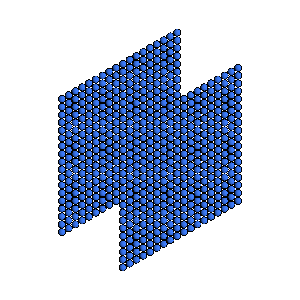

In [4]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

``md.constrain.rigid`` applies the rigid constraint to all the constituent particles, and can also create the constituent particles in the system.

Add the particle type for the constituent particles. Constituents may not share a type with any rigid central particle.

In [5]:
system.particles.types.add('A');

Define each rigid body type in the local coordinate system of the body. This example creates rods 9 particles long. The center of mass particle is at ``(0,0,0)`` and the constituent particles extend to either side.

Recall that the moment of inertia was specified as a length 3 vector [Ix, Iy, Iz]. The positions of the particles in the local reference frame must be such that the moment of inertia tensor is diagonal. The actual values specified need not assume anything about the body, such as point particles - HOOMD takes the moment of inertia as given and uses it directly in the equations of motion. Above, these bodies are initialized as if they are ideal line segments of length 8.

In [6]:
rigid = hoomd.md.constrain.rigid();
rigid.set_param('R', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

Instruct the rigid constraint to create the constituent particles.

In [7]:
rigid.create_bodies()

notice(2): constrain.rigid(): Creating 648 rigid bodies (adding 5184 particles)


Now, the rods are complete.

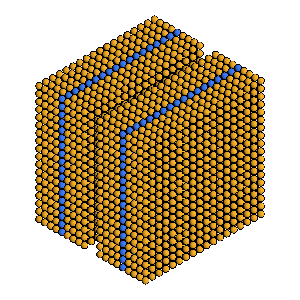

In [8]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

## Define the potential energy

The WCA potential has the same functional form as Lennard-Jones, but $r_\mathrm{cut}=2^{1/6}\sigma$ and is shifted up to 0 at the cutoff.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

In [9]:
nl = hoomd.md.nlist.cell()

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure.

In [10]:
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')

Specify pair potential parameters for every pair of types in the simulation. The particle types *R* and *A* exist in the system for the rigid bodies, but both should interact identically. The *R* particle in the center of the rod is a part of the rod.

In [11]:
lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

## Select integrator

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

In [12]:
hoomd.md.integrate.mode_standard(dt=0.005);

Apply the Langevin equations of motion to all the rigid center of mass particles. $kT$ defines the temperature of the system in energy units and *seed* defines the seed for the random number generator. If there were non-rigid particles in this system, the same integrator could apply to both. Do **not** apply an integrator to constituent particles.

In [13]:
rigid = hoomd.group.rigid_center();
hoomd.md.integrate.langevin(group=rigid, kT=1.0, seed=42);

notice(2): Group "rigid_center" created containing 648 particles
notice(2): integrate.langevin/bd is using specified gamma values


## Write output

Periodically log the potential energy of the system to a text file.

In [14]:
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy',
                              'translational_kinetic_energy',
                              'rotational_kinetic_energy'],
                  period=100,
                  overwrite=True);

Periodically write the particle configurations to a gsd file.

In [15]:
hoomd.dump.gsd("trajectory.gsd",
               period=2e3,
               group=hoomd.group.all(),
               overwrite=True);     

## Run the simulation

Take 10,000 steps forward in time.

In [16]:
hoomd.run(1e4);

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 5832
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:04 | Step 10000 / 10000 | TPS 2558.35 | ETA 00:00:00
Average TPS: 2552.41
---------
-- Neighborlist stats:
1727 normal updates / 35 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 12 / n_neigh_avg: 6.40638
shortest rebuild period: 4
-- Cell list stats:
Dimension: 14, 14, 14
n_min    : 0 / n_max: 7 / n_avg: 2.12536
** run complete **


## Examine the output

Use matplotlib to plot the potential energy vs time step.

In [17]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

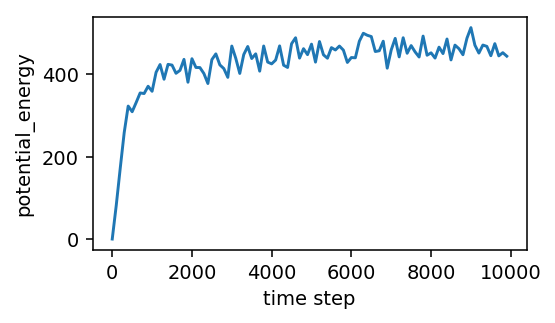

In [18]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

Notice that the average rotational kinetic energy is 2/3 of the translational. This is consistent with the equipartition theorem: the rods have 3 translational degrees of freedom but only 2 rotational ones. HOOMD determined the number of rotational degrees of freedom from the moment of inertia tensor provided during initialization. The 0 moment of inertia about *x* notified HOOMD that the bodies should not rotate about that axis.

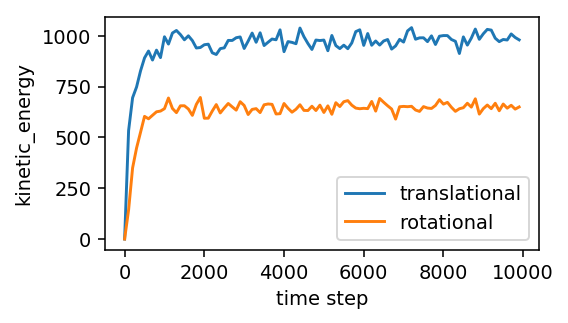

In [19]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,2]);
pyplot.plot(data[:,0], data[:,3]);
pyplot.xlabel('time step');
pyplot.ylabel('kinetic_energy');
pyplot.legend(['translational', 'rotational'], loc='lower right');

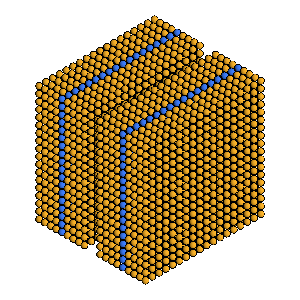

In [20]:
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');